### Imports

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import lightgbm as lgb

### Use functions

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


def distance(x, y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    R = 6373.0 # радиус земли в километрах
    lat_a, long_a, lat_b, long_b = map(radians, [*x, *y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


### Read data

In [3]:
train = pd.read_csv('../input/train.csv', index_col=0)

test = pd.read_csv('../input/test.csv', index_col=0)

In [4]:
train['isTrain'] = True
test['isTrain'] = False

In [5]:
X = train.append(test, sort=False)

### Describe data

In [6]:
X.sample(5, random_state=42)

,id,atm_group,address,address_rus,lat,long,target,isTrain
1226,4238.0,8083.0,Komsomolskiy pr. 13 Neftekamsk,"Комсомольский проспект, 13, Нефтекамск, Респуб...",56.093084,54.252566,0.123189,True
1645,5276.0,5478.0,"D. 13, UL. OKTYABR'SKAYA SHEBEKINO G","Октябрьская улица, 13, Шебекино, Белгородская ...",50.422386,36.899953,NaN,False
1559,903.0,1942.0,3 UCHITELSKAYA STR. SOCHI,"Учительская улица, 3, микрорайон Светлана, Соч...",43.572868,39.735036,-0.000895,True
395,7413.0,5478.0,"D. 20, UL. 70 LET OKTYABR OMSK G","улица 70 лет Октября, 20, Омск, Россия, 644123",54.982156,73.321976,NaN,False
4245,2553.0,3185.5,"KIROVOGRADSKAJA,13A MOSKVA","Кировоградская улица, 13А, Москва, Россия, 117519",55.612182,37.607026,-0.045854,True


In [7]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8765.0,4404.586366,2542.532548,1.000000,2207.000000,4403.000000,6603.000000,8811.000000
atm_group,8765.0,4407.008842,2427.934099,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,8345.0,54.138304,4.329293,42.057080,52.243997,55.060936,56.116673,69.495093
long,8345.0,63.500873,32.787366,19.941530,37.851107,49.071694,84.950218,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [8]:
X.describe(include='object').T

,count,unique,top,freq
address,8765,7481,"HOROSHEVSKOE SH,V38 MOSKVA",7
address_rus,8345,6147,"квартал В-13, городской округ Волгодонск, Рост...",10


In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,6261.0,4419.120827,2547.213467,5.000000,2228.000000,4392.000000,6660.000000,8811.000000
atm_group,6261.0,4417.937230,2430.413287,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,5957.0,54.160017,4.346200,42.057080,52.248916,55.069638,56.122756,69.491912
long,5957.0,63.519692,33.020176,19.941530,37.858986,48.578510,84.951080,173.706490
target,6261.0,0.000715,0.085852,-0.145001,-0.061176,-0.015573,0.040149,0.218608


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2504.0,4368.244409,2530.932485,1.000000,2146.500000,4437.500000,6468.500000,8808.000000
atm_group,2504.0,4379.683506,2421.992871,32.000000,1942.000000,5478.000000,5478.000000,8083.000000
lat,2388.0,54.084141,4.287252,42.648594,52.208846,55.041477,56.102224,69.495093
long,2388.0,63.453926,32.206070,20.442763,37.809960,49.147009,84.947231,160.853844


### Feature engineering

In [11]:
use_columns = [
    'id',
    'atm_group',
    'lat',
    'long',
]

functions = [
    pd.DataFrame.min,
    pd.DataFrame.max,
    pd.DataFrame.mean,
    pd.DataFrame.median,
]

In [12]:
for col in tqdm_notebook(use_columns):
    for f in functions:
        features = X[use_columns].groupby(col, as_index=False).apply(f)
        X = pd.merge(X, features, how='left', on=col, suffixes=('', '_{}'.format(f)))

In [13]:
for col in ['address', 'address_rus']:
    f = pd.DataFrame.count
    features = X[['id', col]].groupby(col)[['id']].apply(f).reset_index()
    X = pd.merge(X, features, how='left', on=col, suffixes=('', '_{}'.format(f)))

In [14]:
dots = X[['lat','long']].dropna()

In [15]:
knc = KNeighborsClassifier(metric=distance)
knc.fit(X=dots, y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7fb8bbe72840>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [16]:
distances, indexes = knc.kneighbors(X=dots,n_neighbors=6,)

In [17]:
for i in range(1,distances.shape[1]):
    dots['distance_%s'%i] = distances[:,i]
    dots['indexes_%s'%i] = indexes[:,i]

In [18]:
dots['mean'] = dots.iloc[:,dots.columns.str.contains('distance')].mean(axis=1)

In [19]:
X = pd.concat([X,dots], axis=1)

### Город размещения

In [20]:
X['city'] = X[~X.address_rus.isnull()].address_rus.apply(lambda x: x.split(',')[2]) 

In [21]:
rare_cities = X.city.value_counts()[(X.city.value_counts() < 20) ==True].index

In [22]:
X.city = X.city.apply(lambda x: 'RARE' if x in rare_cities else x)

In [23]:
X.city= X.city.rank().fillna(-1)

In [24]:
X_new = X.loc[X.isTrain].drop([
    'target',
    'isTrain',
    'address',
    'address_rus',
], axis=1)

Y_new = X.loc[X.isTrain, 'target']

In [25]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_new, Y_new, test_size=0.2, random_state=42)

In [26]:
gbm = lgb.LGBMRegressor(
                            objective = 'regression',  
                            max_depth = -1,
                            colsample_bytree = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.01,
                            n_estimators = 100000,
                            random_state=42,
                        )

In [27]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's rmse: 0.0848201	valid_0's l2: 0.00719445
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.084216	valid_0's l2: 0.00709234
[3]	valid_0's rmse: 0.0836174	valid_0's l2: 0.00699187
[4]	valid_0's rmse: 0.0830261	valid_0's l2: 0.00689334
[5]	valid_0's rmse: 0.0824391	valid_0's l2: 0.0067962
[6]	valid_0's rmse: 0.0818653	valid_0's l2: 0.00670193
[7]	valid_0's rmse: 0.0813013	valid_0's l2: 0.0066099
[8]	valid_0's rmse: 0.0807393	valid_0's l2: 0.00651883
[9]	valid_0's rmse: 0.0801842	valid_0's l2: 0.00642951
[10]	valid_0's rmse: 0.0796421	valid_0's l2: 0.00634286
[11]	valid_0's rmse: 0.0791023	valid_0's l2: 0.00625718
[12]	valid_0's rmse: 0.0785699	valid_0's l2: 0.00617322
[13]	valid_0's rmse: 0.0780434	valid_0's l2: 0.00609077
[14]	valid_0's rmse: 0.077524	valid_0's l2: 0.00600997


[15]	valid_0's rmse: 0.0770212	valid_0's l2: 0.00593227
[16]	valid_0's rmse: 0.0765133	valid_0's l2: 0.00585429
[17]	valid_0's rmse: 0.0760176	valid_0's l2: 0.00577868
[18]	valid_0's rmse: 0.075532	valid_0's l2: 0.00570508


[19]	valid_0's rmse: 0.075052	valid_0's l2: 0.0056328
[20]	valid_0's rmse: 0.0745773	valid_0's l2: 0.00556177
[21]	valid_0's rmse: 0.0741108	valid_0's l2: 0.00549241
[22]	valid_0's rmse: 0.0736454	valid_0's l2: 0.00542364
[23]	valid_0's rmse: 0.0731898	valid_0's l2: 0.00535674
[24]	valid_0's rmse: 0.0727459	valid_0's l2: 0.00529197
[25]	valid_0's rmse: 0.0723035	valid_0's l2: 0.0052278
[26]	valid_0's rmse: 0.07186	valid_0's l2: 0.00516386
[27]	valid_0's rmse: 0.0714283	valid_0's l2: 0.005102
[28]	valid_0's rmse: 0.0709993	valid_0's l2: 0.00504089
[29]	valid_0's rmse: 0.0705772	valid_0's l2: 0.00498114


[30]	valid_0's rmse: 0.0701567	valid_0's l2: 0.00492196
[31]	valid_0's rmse: 0.0697482	valid_0's l2: 0.00486481
[32]	valid_0's rmse: 0.0693456	valid_0's l2: 0.00480881
[33]	valid_0's rmse: 0.068947	valid_0's l2: 0.00475369
[34]	valid_0's rmse: 0.0685584	valid_0's l2: 0.00470025
[35]	valid_0's rmse: 0.0681727	valid_0's l2: 0.00464752
[36]	valid_0's rmse: 0.0677978	valid_0's l2: 0.00459654
[37]	valid_0's rmse: 0.0674229	valid_0's l2: 0.00454585
[38]	valid_0's rmse: 0.0670514	valid_0's l2: 0.00449589
[39]	valid_0's rmse: 0.0666892	valid_0's l2: 0.00444746
[40]	valid_0's rmse: 0.0663301	valid_0's l2: 0.00439968
[41]	valid_0's rmse: 0.0659774	valid_0's l2: 0.00435302
[42]	valid_0's rmse: 0.0656297	valid_0's l2: 0.00430726
[43]	valid_0's rmse: 0.0652848	valid_0's l2: 0.00426211
[44]	valid_0's rmse: 0.0649494	valid_0's l2: 0.00421843
[45]	valid_0's rmse: 0.0646154	valid_0's l2: 0.00417515
[46]	valid_0's rmse: 0.064288	valid_0's l2: 0.00413295
[47]	valid_0's rmse: 0.0639659	valid_0's l2: 0.004


[51]	valid_0's rmse: 0.0627274	valid_0's l2: 0.00393473
[52]	valid_0's rmse: 0.062431	valid_0's l2: 0.00389763
[53]	valid_0's rmse: 0.0621385	valid_0's l2: 0.0038612
[54]	valid_0's rmse: 0.0618509	valid_0's l2: 0.00382553
[55]	valid_0's rmse: 0.0615691	valid_0's l2: 0.00379075
[56]	valid_0's rmse: 0.0612883	valid_0's l2: 0.00375626
[57]	valid_0's rmse: 0.0610099	valid_0's l2: 0.00372221
[58]	valid_0's rmse: 0.0607288	valid_0's l2: 0.00368799
[59]	valid_0's rmse: 0.0604569	valid_0's l2: 0.00365504
[60]	valid_0's rmse: 0.0601874	valid_0's l2: 0.00362252
[61]	valid_0's rmse: 0.059923	valid_0's l2: 0.00359077
[62]	valid_0's rmse: 0.0596658	valid_0's l2: 0.00356


[63]	valid_0's rmse: 0.059416	valid_0's l2: 0.00353026
[64]	valid_0's rmse: 0.0591717	valid_0's l2: 0.00350129
[65]	valid_0's rmse: 0.0589231	valid_0's l2: 0.00347194
[66]	valid_0's rmse: 0.058682	valid_0's l2: 0.00344358
[67]	valid_0's rmse: 0.0584512	valid_0's l2: 0.00341655
[68]	valid_0's rmse: 0.0582195	valid_0's l2: 0.0033895
[69]	valid_0's rmse: 0.0579879	valid_0's l2: 0.0033626
[70]	valid_0's rmse: 0.057757	valid_0's l2: 0.00333587
[71]	valid_0's rmse: 0.0575377	valid_0's l2: 0.00331059
[72]	valid_0's rmse: 0.0573215	valid_0's l2: 0.00328575
[73]	valid_0's rmse: 0.0571027	valid_0's l2: 0.00326072
[74]	valid_0's rmse: 0.0568917	valid_0's l2: 0.00323666
[75]	valid_0's rmse: 0.0566887	valid_0's l2: 0.00321361
[76]	valid_0's rmse: 0.0564803	valid_0's l2: 0.00319002
[77]	valid_0's rmse: 0.056282	valid_0's l2: 0.00316767
[78]	valid_0's rmse: 0.0560824	valid_0's l2: 0.00314523
[79]	valid_0's rmse: 0.0558867	valid_0's l2: 0.00312333


[80]	valid_0's rmse: 0.0556948	valid_0's l2: 0.00310191
[81]	valid_0's rmse: 0.0555028	valid_0's l2: 0.00308056
[82]	valid_0's rmse: 0.0553116	valid_0's l2: 0.00305937
[83]	valid_0's rmse: 0.0551282	valid_0's l2: 0.00303912
[84]	valid_0's rmse: 0.0549443	valid_0's l2: 0.00301888
[85]	valid_0's rmse: 0.0547712	valid_0's l2: 0.00299988
[86]	valid_0's rmse: 0.0545976	valid_0's l2: 0.00298089
[87]	valid_0's rmse: 0.0544253	valid_0's l2: 0.00296211
[88]	valid_0's rmse: 0.0542514	valid_0's l2: 0.00294321
[89]	valid_0's rmse: 0.0540828	valid_0's l2: 0.00292495
[90]	valid_0's rmse: 0.0539194	valid_0's l2: 0.0029073
[91]	valid_0's rmse: 0.0537539	valid_0's l2: 0.00288948
[92]	valid_0's rmse: 0.0535957	valid_0's l2: 0.0028725
[93]	valid_0's rmse: 0.0534415	valid_0's l2: 0.00285599
[94]	valid_0's rmse: 0.0532919	valid_0's l2: 0.00284002
[95]	valid_0's rmse: 0.0531398	valid_0's l2: 0.00282384
[96]	valid_0's rmse: 0.0529875	valid_0's l2: 0.00280768
[97]	valid_0's rmse: 0.0528454	valid_0's l2: 0.002

[103]	valid_0's rmse: 0.0520192	valid_0's l2: 0.002706
[104]	valid_0's rmse: 0.0518913	valid_0's l2: 0.0026927
[105]	valid_0's rmse: 0.0517581	valid_0's l2: 0.0026789
[106]	valid_0's rmse: 0.0516293	valid_0's l2: 0.00266558
[107]	valid_0's rmse: 0.0515043	valid_0's l2: 0.00265269
[108]	valid_0's rmse: 0.0513825	valid_0's l2: 0.00264016
[109]	valid_0's rmse: 0.0512641	valid_0's l2: 0.002628
[110]	valid_0's rmse: 0.0511447	valid_0's l2: 0.00261578
[111]	valid_0's rmse: 0.0510292	valid_0's l2: 0.00260398
[112]	valid_0's rmse: 0.0509203	valid_0's l2: 0.00259288
[113]	valid_0's rmse: 0.0508035	valid_0's l2: 0.00258099
[114]	valid_0's rmse: 0.0506916	valid_0's l2: 0.00256964
[115]	valid_0's rmse: 0.0505789	valid_0's l2: 0.00255822
[116]	valid_0's rmse: 0.0504727	valid_0's l2: 0.0025475
[117]	valid_0's rmse: 0.0503695	valid_0's l2: 0.00253709
[118]	valid_0's rmse: 0.0502694	valid_0's l2: 0.00252702
[119]	valid_0's rmse: 0.050168	valid_0's l2: 0.00251682
[120]	valid_0's rmse: 0.0500636	valid_0

[124]	valid_0's rmse: 0.0496812	valid_0's l2: 0.00246822
[125]	valid_0's rmse: 0.0495974	valid_0's l2: 0.0024599
[126]	valid_0's rmse: 0.0495088	valid_0's l2: 0.00245112
[127]	valid_0's rmse: 0.0494197	valid_0's l2: 0.0024423
[128]	valid_0's rmse: 0.0493307	valid_0's l2: 0.00243352
[129]	valid_0's rmse: 0.0492437	valid_0's l2: 0.00242494
[130]	valid_0's rmse: 0.0491617	valid_0's l2: 0.00241687
[131]	valid_0's rmse: 0.0490808	valid_0's l2: 0.00240892
[132]	valid_0's rmse: 0.0490008	valid_0's l2: 0.00240108
[133]	valid_0's rmse: 0.0489248	valid_0's l2: 0.00239363
[134]	valid_0's rmse: 0.0488569	valid_0's l2: 0.002387
[135]	valid_0's rmse: 0.0487804	valid_0's l2: 0.00237953
[136]	valid_0's rmse: 0.0487092	valid_0's l2: 0.00237259
[137]	valid_0's rmse: 0.0486379	valid_0's l2: 0.00236564
[138]	valid_0's rmse: 0.0485676	valid_0's l2: 0.00235881
[139]	valid_0's rmse: 0.0484989	valid_0's l2: 0.00235214
[140]	valid_0's rmse: 0.0484255	valid_0's l2: 0.00234503
[141]	valid_0's rmse: 0.0483558	val

[144]	valid_0's rmse: 0.0481697	valid_0's l2: 0.00232032
[145]	valid_0's rmse: 0.0481022	valid_0's l2: 0.00231382
[146]	valid_0's rmse: 0.0480363	valid_0's l2: 0.00230748
[147]	valid_0's rmse: 0.0479785	valid_0's l2: 0.00230194
[148]	valid_0's rmse: 0.0479256	valid_0's l2: 0.00229686
[149]	valid_0's rmse: 0.0478706	valid_0's l2: 0.00229159
[150]	valid_0's rmse: 0.0478192	valid_0's l2: 0.00228667
[151]	valid_0's rmse: 0.0477631	valid_0's l2: 0.00228132
[152]	valid_0's rmse: 0.0477104	valid_0's l2: 0.00227628
[153]	valid_0's rmse: 0.0476545	valid_0's l2: 0.00227096
[154]	valid_0's rmse: 0.0476029	valid_0's l2: 0.00226603
[155]	valid_0's rmse: 0.0475537	valid_0's l2: 0.00226135
[156]	valid_0's rmse: 0.047507	valid_0's l2: 0.00225692
[157]	valid_0's rmse: 0.0474611	valid_0's l2: 0.00225255
[158]	valid_0's rmse: 0.0474082	valid_0's l2: 0.00224753
[159]	valid_0's rmse: 0.0473571	valid_0's l2: 0.0022427
[160]	valid_0's rmse: 0.0473127	valid_0's l2: 0.00223849
[161]	valid_0's rmse: 0.0472619	v

[168]	valid_0's rmse: 0.0469532	valid_0's l2: 0.0022046
[169]	valid_0's rmse: 0.0469142	valid_0's l2: 0.00220095
[170]	valid_0's rmse: 0.046875	valid_0's l2: 0.00219727
[171]	valid_0's rmse: 0.0468378	valid_0's l2: 0.00219378
[172]	valid_0's rmse: 0.0468045	valid_0's l2: 0.00219066
[173]	valid_0's rmse: 0.0467592	valid_0's l2: 0.00218643
[174]	valid_0's rmse: 0.046722	valid_0's l2: 0.00218295
[175]	valid_0's rmse: 0.0466863	valid_0's l2: 0.00217961
[176]	valid_0's rmse: 0.046644	valid_0's l2: 0.00217566
[177]	valid_0's rmse: 0.04661	valid_0's l2: 0.00217249
[178]	valid_0's rmse: 0.0465746	valid_0's l2: 0.00216919
[179]	valid_0's rmse: 0.0465362	valid_0's l2: 0.00216562
[180]	valid_0's rmse: 0.0465004	valid_0's l2: 0.00216229
[181]	valid_0's rmse: 0.0464659	valid_0's l2: 0.00215908
[182]	valid_0's rmse: 0.0464282	valid_0's l2: 0.00215558
[183]	valid_0's rmse: 0.0463977	valid_0's l2: 0.00215275
[184]	valid_0's rmse: 0.0463641	valid_0's l2: 0.00214963
[185]	valid_0's rmse: 0.0463299	valid

[193]	valid_0's rmse: 0.0460836	valid_0's l2: 0.0021237
[194]	valid_0's rmse: 0.0460577	valid_0's l2: 0.00212132
[195]	valid_0's rmse: 0.0460247	valid_0's l2: 0.00211827
[196]	valid_0's rmse: 0.0459967	valid_0's l2: 0.0021157
[197]	valid_0's rmse: 0.0459659	valid_0's l2: 0.00211287
[198]	valid_0's rmse: 0.0459428	valid_0's l2: 0.00211074
[199]	valid_0's rmse: 0.045916	valid_0's l2: 0.00210828
[200]	valid_0's rmse: 0.0458891	valid_0's l2: 0.00210581
[201]	valid_0's rmse: 0.0458636	valid_0's l2: 0.00210347
[202]	valid_0's rmse: 0.0458391	valid_0's l2: 0.00210123
[203]	valid_0's rmse: 0.0458103	valid_0's l2: 0.00209858
[204]	valid_0's rmse: 0.0457912	valid_0's l2: 0.00209684
[205]	valid_0's rmse: 0.0457691	valid_0's l2: 0.00209481
[206]	valid_0's rmse: 0.0457469	valid_0's l2: 0.00209278
[207]	valid_0's rmse: 0.0457322	valid_0's l2: 0.00209143
[208]	valid_0's rmse: 0.0457072	valid_0's l2: 0.00208915
[209]	valid_0's rmse: 0.0456899	valid_0's l2: 0.00208757
[210]	valid_0's rmse: 0.0456698	va

[214]	valid_0's rmse: 0.0455763	valid_0's l2: 0.0020772
[215]	valid_0's rmse: 0.0455571	valid_0's l2: 0.00207545
[216]	valid_0's rmse: 0.045542	valid_0's l2: 0.00207408
[217]	valid_0's rmse: 0.0455195	valid_0's l2: 0.00207203
[218]	valid_0's rmse: 0.0455038	valid_0's l2: 0.00207059
[219]	valid_0's rmse: 0.0454872	valid_0's l2: 0.00206909
[220]	valid_0's rmse: 0.0454629	valid_0's l2: 0.00206688
[221]	valid_0's rmse: 0.0454401	valid_0's l2: 0.0020648
[222]	valid_0's rmse: 0.0454197	valid_0's l2: 0.00206295
[223]	valid_0's rmse: 0.045398	valid_0's l2: 0.00206098
[224]	valid_0's rmse: 0.0453857	valid_0's l2: 0.00205987
[225]	valid_0's rmse: 0.0453655	valid_0's l2: 0.00205803
[226]	valid_0's rmse: 0.0453478	valid_0's l2: 0.00205642
[227]	valid_0's rmse: 0.0453303	valid_0's l2: 0.00205484
[228]	valid_0's rmse: 0.0453069	valid_0's l2: 0.00205272
[229]	valid_0's rmse: 0.0452925	valid_0's l2: 0.00205141
[230]	valid_0's rmse: 0.0452719	valid_0's l2: 0.00204955
[231]	valid_0's rmse: 0.0452536	val

[236]	valid_0's rmse: 0.0451783	valid_0's l2: 0.00204108
[237]	valid_0's rmse: 0.0451614	valid_0's l2: 0.00203955
[238]	valid_0's rmse: 0.0451481	valid_0's l2: 0.00203835
[239]	valid_0's rmse: 0.0451322	valid_0's l2: 0.00203691
[240]	valid_0's rmse: 0.0451119	valid_0's l2: 0.00203508
[241]	valid_0's rmse: 0.0450992	valid_0's l2: 0.00203394
[242]	valid_0's rmse: 0.0450797	valid_0's l2: 0.00203218
[243]	valid_0's rmse: 0.0450665	valid_0's l2: 0.00203099
[244]	valid_0's rmse: 0.0450514	valid_0's l2: 0.00202963


[245]	valid_0's rmse: 0.0450375	valid_0's l2: 0.00202838
[246]	valid_0's rmse: 0.0450263	valid_0's l2: 0.00202737
[247]	valid_0's rmse: 0.045009	valid_0's l2: 0.00202581
[248]	valid_0's rmse: 0.0449989	valid_0's l2: 0.0020249
[249]	valid_0's rmse: 0.0449816	valid_0's l2: 0.00202334
[250]	valid_0's rmse: 0.0449645	valid_0's l2: 0.00202181
[251]	valid_0's rmse: 0.0449503	valid_0's l2: 0.00202053
[252]	valid_0's rmse: 0.0449354	valid_0's l2: 0.00201919
[253]	valid_0's rmse: 0.0449177	valid_0's l2: 0.0020176
[254]	valid_0's rmse: 0.0449047	valid_0's l2: 0.00201643
[255]	valid_0's rmse: 0.044889	valid_0's l2: 0.00201503


[256]	valid_0's rmse: 0.0448773	valid_0's l2: 0.00201398
[257]	valid_0's rmse: 0.0448582	valid_0's l2: 0.00201226
[258]	valid_0's rmse: 0.0448403	valid_0's l2: 0.00201065
[259]	valid_0's rmse: 0.0448273	valid_0's l2: 0.00200949
[260]	valid_0's rmse: 0.0448117	valid_0's l2: 0.00200809
[261]	valid_0's rmse: 0.0448004	valid_0's l2: 0.00200707
[262]	valid_0's rmse: 0.0447852	valid_0's l2: 0.00200572
[263]	valid_0's rmse: 0.0447653	valid_0's l2: 0.00200393
[264]	valid_0's rmse: 0.0447543	valid_0's l2: 0.00200295
[265]	valid_0's rmse: 0.0447392	valid_0's l2: 0.0020016
[266]	valid_0's rmse: 0.0447292	valid_0's l2: 0.0020007
[267]	valid_0's rmse: 0.0447091	valid_0's l2: 0.00199891
[268]	valid_0's rmse: 0.0446969	valid_0's l2: 0.00199782


[269]	valid_0's rmse: 0.0446863	valid_0's l2: 0.00199687
[270]	valid_0's rmse: 0.0446749	valid_0's l2: 0.00199585
[271]	valid_0's rmse: 0.0446597	valid_0's l2: 0.00199449
[272]	valid_0's rmse: 0.0446449	valid_0's l2: 0.00199317
[273]	valid_0's rmse: 0.0446359	valid_0's l2: 0.00199237
[274]	valid_0's rmse: 0.0446282	valid_0's l2: 0.00199168
[275]	valid_0's rmse: 0.0446112	valid_0's l2: 0.00199016
[276]	valid_0's rmse: 0.0446021	valid_0's l2: 0.00198935
[277]	valid_0's rmse: 0.0445946	valid_0's l2: 0.00198868
[278]	valid_0's rmse: 0.0445816	valid_0's l2: 0.00198752
[279]	valid_0's rmse: 0.0445718	valid_0's l2: 0.00198664
[280]	valid_0's rmse: 0.044566	valid_0's l2: 0.00198613
[281]	valid_0's rmse: 0.0445506	valid_0's l2: 0.00198475


[282]	valid_0's rmse: 0.0445418	valid_0's l2: 0.00198397
[283]	valid_0's rmse: 0.044533	valid_0's l2: 0.00198319
[284]	valid_0's rmse: 0.0445262	valid_0's l2: 0.00198259
[285]	valid_0's rmse: 0.044511	valid_0's l2: 0.00198123
[286]	valid_0's rmse: 0.044496	valid_0's l2: 0.00197989
[287]	valid_0's rmse: 0.0444889	valid_0's l2: 0.00197926
[288]	valid_0's rmse: 0.0444818	valid_0's l2: 0.00197863
[289]	valid_0's rmse: 0.044471	valid_0's l2: 0.00197767
[290]	valid_0's rmse: 0.0444586	valid_0's l2: 0.00197657
[291]	valid_0's rmse: 0.0444501	valid_0's l2: 0.00197581
[292]	valid_0's rmse: 0.0444434	valid_0's l2: 0.00197522
[293]	valid_0's rmse: 0.0444359	valid_0's l2: 0.00197455
[294]	valid_0's rmse: 0.0444313	valid_0's l2: 0.00197414
[295]	valid_0's rmse: 0.0444224	valid_0's l2: 0.00197335
[296]	valid_0's rmse: 0.0444133	valid_0's l2: 0.00197254


[297]	valid_0's rmse: 0.0444075	valid_0's l2: 0.00197203
[298]	valid_0's rmse: 0.0444044	valid_0's l2: 0.00197175
[299]	valid_0's rmse: 0.0443955	valid_0's l2: 0.00197096
[300]	valid_0's rmse: 0.0443865	valid_0's l2: 0.00197016
[301]	valid_0's rmse: 0.0443832	valid_0's l2: 0.00196987
[302]	valid_0's rmse: 0.0443779	valid_0's l2: 0.0019694
[303]	valid_0's rmse: 0.0443725	valid_0's l2: 0.00196892
[304]	valid_0's rmse: 0.0443655	valid_0's l2: 0.0019683
[305]	valid_0's rmse: 0.0443604	valid_0's l2: 0.00196785
[306]	valid_0's rmse: 0.0443573	valid_0's l2: 0.00196757
[307]	valid_0's rmse: 0.0443464	valid_0's l2: 0.00196661
[308]	valid_0's rmse: 0.0443392	valid_0's l2: 0.00196596
[309]	valid_0's rmse: 0.0443326	valid_0's l2: 0.00196538
[310]	valid_0's rmse: 0.0443257	valid_0's l2: 0.00196477
[311]	valid_0's rmse: 0.0443259	valid_0's l2: 0.00196478
[312]	valid_0's rmse: 0.0443242	valid_0's l2: 0.00196463
[313]	valid_0's rmse: 0.044312	valid_0's l2: 0.00196356
[314]	valid_0's rmse: 0.0443027	va

[325]	valid_0's rmse: 0.0442201	valid_0's l2: 0.00195542
[326]	valid_0's rmse: 0.0442138	valid_0's l2: 0.00195486
[327]	valid_0's rmse: 0.0442034	valid_0's l2: 0.00195394
[328]	valid_0's rmse: 0.0441926	valid_0's l2: 0.00195299
[329]	valid_0's rmse: 0.04419	valid_0's l2: 0.00195276
[330]	valid_0's rmse: 0.0441823	valid_0's l2: 0.00195208
[331]	valid_0's rmse: 0.0441742	valid_0's l2: 0.00195136
[332]	valid_0's rmse: 0.0441679	valid_0's l2: 0.0019508
[333]	valid_0's rmse: 0.0441687	valid_0's l2: 0.00195088
[334]	valid_0's rmse: 0.0441654	valid_0's l2: 0.00195058
[335]	valid_0's rmse: 0.0441537	valid_0's l2: 0.00194955
[336]	valid_0's rmse: 0.0441499	valid_0's l2: 0.00194922
[337]	valid_0's rmse: 0.0441473	valid_0's l2: 0.00194899
[338]	valid_0's rmse: 0.0441353	valid_0's l2: 0.00194792
[339]	valid_0's rmse: 0.0441323	valid_0's l2: 0.00194766
[340]	valid_0's rmse: 0.0441267	valid_0's l2: 0.00194716
[341]	valid_0's rmse: 0.0441213	valid_0's l2: 0.00194669
[342]	valid_0's rmse: 0.0441157	va

[349]	valid_0's rmse: 0.0440962	valid_0's l2: 0.00194448
[350]	valid_0's rmse: 0.0440901	valid_0's l2: 0.00194394
[351]	valid_0's rmse: 0.0440879	valid_0's l2: 0.00194374
[352]	valid_0's rmse: 0.044082	valid_0's l2: 0.00194322
[353]	valid_0's rmse: 0.0440707	valid_0's l2: 0.00194223
[354]	valid_0's rmse: 0.0440661	valid_0's l2: 0.00194182
[355]	valid_0's rmse: 0.0440635	valid_0's l2: 0.0019416
[356]	valid_0's rmse: 0.0440619	valid_0's l2: 0.00194145
[357]	valid_0's rmse: 0.0440587	valid_0's l2: 0.00194117
[358]	valid_0's rmse: 0.0440523	valid_0's l2: 0.00194061
[359]	valid_0's rmse: 0.0440491	valid_0's l2: 0.00194032
[360]	valid_0's rmse: 0.0440491	valid_0's l2: 0.00194032
[361]	valid_0's rmse: 0.0440422	valid_0's l2: 0.00193972
[362]	valid_0's rmse: 0.0440431	valid_0's l2: 0.00193979
[363]	valid_0's rmse: 0.0440333	valid_0's l2: 0.00193894


[364]	valid_0's rmse: 0.0440313	valid_0's l2: 0.00193876
[365]	valid_0's rmse: 0.044029	valid_0's l2: 0.00193855
[366]	valid_0's rmse: 0.044028	valid_0's l2: 0.00193846
[367]	valid_0's rmse: 0.0440189	valid_0's l2: 0.00193766
[368]	valid_0's rmse: 0.0440179	valid_0's l2: 0.00193757
[369]	valid_0's rmse: 0.044013	valid_0's l2: 0.00193715
[370]	valid_0's rmse: 0.0440131	valid_0's l2: 0.00193715
[371]	valid_0's rmse: 0.0440093	valid_0's l2: 0.00193682


[372]	valid_0's rmse: 0.0440072	valid_0's l2: 0.00193664
[373]	valid_0's rmse: 0.0440021	valid_0's l2: 0.00193619
[374]	valid_0's rmse: 0.0439955	valid_0's l2: 0.00193561
[375]	valid_0's rmse: 0.0439905	valid_0's l2: 0.00193517
[376]	valid_0's rmse: 0.0439904	valid_0's l2: 0.00193515
[377]	valid_0's rmse: 0.0439869	valid_0's l2: 0.00193485
[378]	valid_0's rmse: 0.0439813	valid_0's l2: 0.00193436
[379]	valid_0's rmse: 0.0439763	valid_0's l2: 0.00193392
[380]	valid_0's rmse: 0.0439719	valid_0's l2: 0.00193353
[381]	valid_0's rmse: 0.0439703	valid_0's l2: 0.00193339
[382]	valid_0's rmse: 0.043967	valid_0's l2: 0.0019331
[383]	valid_0's rmse: 0.0439633	valid_0's l2: 0.00193277
[384]	valid_0's rmse: 0.0439615	valid_0's l2: 0.00193261
[385]	valid_0's rmse: 0.0439597	valid_0's l2: 0.00193245
[386]	valid_0's rmse: 0.0439575	valid_0's l2: 0.00193226
[387]	valid_0's rmse: 0.043951	valid_0's l2: 0.00193169
[388]	valid_0's rmse: 0.0439506	valid_0's l2: 0.00193165
[389]	valid_0's rmse: 0.0439481	va


[401]	valid_0's rmse: 0.0439266	valid_0's l2: 0.00192954
[402]	valid_0's rmse: 0.0439227	valid_0's l2: 0.00192921
[403]	valid_0's rmse: 0.0439214	valid_0's l2: 0.00192909
[404]	valid_0's rmse: 0.0439182	valid_0's l2: 0.00192881
[405]	valid_0's rmse: 0.0439164	valid_0's l2: 0.00192865
[406]	valid_0's rmse: 0.0439182	valid_0's l2: 0.00192881
[407]	valid_0's rmse: 0.0439145	valid_0's l2: 0.00192848
[408]	valid_0's rmse: 0.0439091	valid_0's l2: 0.00192801
[409]	valid_0's rmse: 0.0439055	valid_0's l2: 0.0019277
[410]	valid_0's rmse: 0.0439068	valid_0's l2: 0.00192781
[411]	valid_0's rmse: 0.0439019	valid_0's l2: 0.00192738
[412]	valid_0's rmse: 0.0439018	valid_0's l2: 0.00192737
[413]	valid_0's rmse: 0.0438967	valid_0's l2: 0.00192692
[414]	valid_0's rmse: 0.0438949	valid_0's l2: 0.00192676
[415]	valid_0's rmse: 0.0438946	valid_0's l2: 0.00192674
[416]	valid_0's rmse: 0.0438888	valid_0's l2: 0.00192623
[417]	valid_0's rmse: 0.0438824	valid_0's l2: 0.00192567
[418]	valid_0's rmse: 0.0438754

[433]	valid_0's rmse: 0.0438261	valid_0's l2: 0.00192073
[434]	valid_0's rmse: 0.0438267	valid_0's l2: 0.00192078
[435]	valid_0's rmse: 0.0438264	valid_0's l2: 0.00192076
[436]	valid_0's rmse: 0.0438212	valid_0's l2: 0.0019203
[437]	valid_0's rmse: 0.0438174	valid_0's l2: 0.00191996
[438]	valid_0's rmse: 0.0438138	valid_0's l2: 0.00191965
[439]	valid_0's rmse: 0.0438112	valid_0's l2: 0.00191942
[440]	valid_0's rmse: 0.04381	valid_0's l2: 0.00191931
[441]	valid_0's rmse: 0.0438045	valid_0's l2: 0.00191884
[442]	valid_0's rmse: 0.0438027	valid_0's l2: 0.00191868
[443]	valid_0's rmse: 0.0437977	valid_0's l2: 0.00191824
[444]	valid_0's rmse: 0.0437942	valid_0's l2: 0.00191793
[445]	valid_0's rmse: 0.0437936	valid_0's l2: 0.00191788
[446]	valid_0's rmse: 0.0437888	valid_0's l2: 0.00191746
[447]	valid_0's rmse: 0.0437857	valid_0's l2: 0.00191718
[448]	valid_0's rmse: 0.0437803	valid_0's l2: 0.00191671
[449]	valid_0's rmse: 0.0437739	valid_0's l2: 0.00191615
[450]	valid_0's rmse: 0.0437739	va


[488]	valid_0's rmse: 0.0435759	valid_0's l2: 0.00189886
[489]	valid_0's rmse: 0.0435738	valid_0's l2: 0.00189868
[490]	valid_0's rmse: 0.0435684	valid_0's l2: 0.00189821
[491]	valid_0's rmse: 0.0435657	valid_0's l2: 0.00189797
[492]	valid_0's rmse: 0.0435621	valid_0's l2: 0.00189766
[493]	valid_0's rmse: 0.0435563	valid_0's l2: 0.00189715
[494]	valid_0's rmse: 0.0435504	valid_0's l2: 0.00189664
[495]	valid_0's rmse: 0.0435476	valid_0's l2: 0.00189639
[496]	valid_0's rmse: 0.0435449	valid_0's l2: 0.00189616
[497]	valid_0's rmse: 0.0435405	valid_0's l2: 0.00189577
[498]	valid_0's rmse: 0.043533	valid_0's l2: 0.00189512
[499]	valid_0's rmse: 0.0435313	valid_0's l2: 0.00189498
[500]	valid_0's rmse: 0.0435272	valid_0's l2: 0.00189462
[501]	valid_0's rmse: 0.0435223	valid_0's l2: 0.00189419
[502]	valid_0's rmse: 0.0435184	valid_0's l2: 0.00189385
[503]	valid_0's rmse: 0.0435127	valid_0's l2: 0.00189335
[504]	valid_0's rmse: 0.0435082	valid_0's l2: 0.00189297
[505]	valid_0's rmse: 0.0435029

[524]	valid_0's rmse: 0.0434538	valid_0's l2: 0.00188823
[525]	valid_0's rmse: 0.043452	valid_0's l2: 0.00188808
[526]	valid_0's rmse: 0.0434501	valid_0's l2: 0.00188791
[527]	valid_0's rmse: 0.043449	valid_0's l2: 0.00188781
[528]	valid_0's rmse: 0.0434456	valid_0's l2: 0.00188752
[529]	valid_0's rmse: 0.0434456	valid_0's l2: 0.00188752
[530]	valid_0's rmse: 0.0434404	valid_0's l2: 0.00188707
[531]	valid_0's rmse: 0.0434365	valid_0's l2: 0.00188673
[532]	valid_0's rmse: 0.0434374	valid_0's l2: 0.00188681
[533]	valid_0's rmse: 0.043431	valid_0's l2: 0.00188625
[534]	valid_0's rmse: 0.0434282	valid_0's l2: 0.00188601
[535]	valid_0's rmse: 0.0434294	valid_0's l2: 0.00188611
[536]	valid_0's rmse: 0.0434293	valid_0's l2: 0.0018861
[537]	valid_0's rmse: 0.0434313	valid_0's l2: 0.00188628
[538]	valid_0's rmse: 0.0434316	valid_0's l2: 0.0018863
[539]	valid_0's rmse: 0.043423	valid_0's l2: 0.00188556
[540]	valid_0's rmse: 0.0434182	valid_0's l2: 0.00188514
[541]	valid_0's rmse: 0.0434101	valid

[579]	valid_0's rmse: 0.0433361	valid_0's l2: 0.00187802
[580]	valid_0's rmse: 0.0433306	valid_0's l2: 0.00187754
[581]	valid_0's rmse: 0.0433261	valid_0's l2: 0.00187715
[582]	valid_0's rmse: 0.0433278	valid_0's l2: 0.0018773
[583]	valid_0's rmse: 0.0433214	valid_0's l2: 0.00187674
[584]	valid_0's rmse: 0.0433201	valid_0's l2: 0.00187663
[585]	valid_0's rmse: 0.0433164	valid_0's l2: 0.00187631
[586]	valid_0's rmse: 0.0433143	valid_0's l2: 0.00187613
[587]	valid_0's rmse: 0.0433166	valid_0's l2: 0.00187633
[588]	valid_0's rmse: 0.0433145	valid_0's l2: 0.00187615
[589]	valid_0's rmse: 0.0433144	valid_0's l2: 0.00187613
[590]	valid_0's rmse: 0.0433138	valid_0's l2: 0.00187608
[591]	valid_0's rmse: 0.0433114	valid_0's l2: 0.00187588
[592]	valid_0's rmse: 0.0433097	valid_0's l2: 0.00187573
[593]	valid_0's rmse: 0.0433104	valid_0's l2: 0.00187579
[594]	valid_0's rmse: 0.0433084	valid_0's l2: 0.00187561
[595]	valid_0's rmse: 0.0433066	valid_0's l2: 0.00187546
[596]	valid_0's rmse: 0.043307	v

[623]	valid_0's rmse: 0.0432699	valid_0's l2: 0.00187229
[624]	valid_0's rmse: 0.043272	valid_0's l2: 0.00187247
[625]	valid_0's rmse: 0.0432684	valid_0's l2: 0.00187216
[626]	valid_0's rmse: 0.043265	valid_0's l2: 0.00187186
[627]	valid_0's rmse: 0.0432635	valid_0's l2: 0.00187173
[628]	valid_0's rmse: 0.0432661	valid_0's l2: 0.00187196
[629]	valid_0's rmse: 0.0432651	valid_0's l2: 0.00187187
[630]	valid_0's rmse: 0.0432648	valid_0's l2: 0.00187184
[631]	valid_0's rmse: 0.0432618	valid_0's l2: 0.00187158
[632]	valid_0's rmse: 0.0432583	valid_0's l2: 0.00187128
[633]	valid_0's rmse: 0.043252	valid_0's l2: 0.00187073
[634]	valid_0's rmse: 0.0432506	valid_0's l2: 0.00187061
[635]	valid_0's rmse: 0.0432498	valid_0's l2: 0.00187055
[636]	valid_0's rmse: 0.04325	valid_0's l2: 0.00187057
[637]	valid_0's rmse: 0.0432491	valid_0's l2: 0.00187048
[638]	valid_0's rmse: 0.0432501	valid_0's l2: 0.00187057
[639]	valid_0's rmse: 0.0432469	valid_0's l2: 0.00187029
[640]	valid_0's rmse: 0.0432429	vali

[648]	valid_0's rmse: 0.0432303	valid_0's l2: 0.00186886
[649]	valid_0's rmse: 0.0432272	valid_0's l2: 0.00186859
[650]	valid_0's rmse: 0.0432263	valid_0's l2: 0.00186851
[651]	valid_0's rmse: 0.0432248	valid_0's l2: 0.00186838
[652]	valid_0's rmse: 0.0432234	valid_0's l2: 0.00186827
[653]	valid_0's rmse: 0.0432227	valid_0's l2: 0.0018682
[654]	valid_0's rmse: 0.0432211	valid_0's l2: 0.00186807
[655]	valid_0's rmse: 0.0432187	valid_0's l2: 0.00186785
[656]	valid_0's rmse: 0.0432154	valid_0's l2: 0.00186757
[657]	valid_0's rmse: 0.0432189	valid_0's l2: 0.00186787
[658]	valid_0's rmse: 0.0432155	valid_0's l2: 0.00186758
[659]	valid_0's rmse: 0.043217	valid_0's l2: 0.00186771
[660]	valid_0's rmse: 0.0432131	valid_0's l2: 0.00186737
[661]	valid_0's rmse: 0.0432164	valid_0's l2: 0.00186766
[662]	valid_0's rmse: 0.0432164	valid_0's l2: 0.00186766
[663]	valid_0's rmse: 0.043216	valid_0's l2: 0.00186762
[664]	valid_0's rmse: 0.0432163	valid_0's l2: 0.00186764
[665]	valid_0's rmse: 0.0432133	va

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       importance_type='split', learning_rate=0.01, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100000, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=42, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

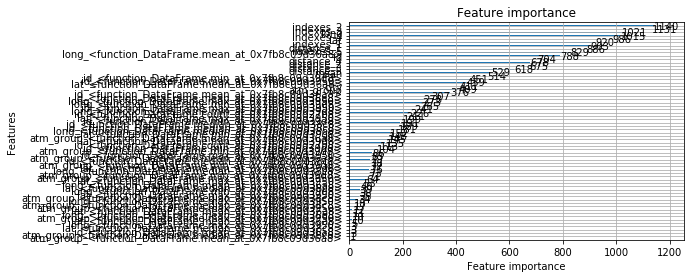

In [28]:
%matplotlib inline
lgb.plot_importance(gbm)

In [29]:
valid_rmse = rmse(Y_valid, gbm.predict(X_valid))
print(valid_rmse)

0.043213082813967414


In [30]:
rmse(Y_valid, np.zeros(Y_valid.shape[0]))

0.08544259844544766

In [31]:
X_test = X.loc[~X.isTrain].drop([
    'target',
    'isTrain',
    'address',
    'address_rus',
], axis=1)

In [32]:
submit = pd.DataFrame(gbm.predict(X_test), index=test.index,columns=['target'])

In [33]:
submit.to_csv('../submits/submit_{}.csv'.format(int(valid_rmse*10e4)))